In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [4]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2016-04-20,442.86,432.51,434.92,74361.53,3.265542e+07,441.16,direct,
2016-04-21,450.80,439.53,441.16,63127.80,2.816877e+07,449.34,direct,
2016-04-22,450.19,441.90,449.34,49710.33,2.222516e+07,445.28,direct,
2016-04-23,451.48,443.07,445.28,42358.77,1.899821e+07,450.08,direct,
2016-04-24,461.78,447.89,450.08,74434.28,3.398427e+07,457.56,direct,
...,...,...,...,...,...,...,...,...
2021-10-07,55359.77,53391.93,55343.24,33806.76,1.836530e+09,53797.21,direct,
2021-10-08,56047.91,53666.09,53796.22,29127.91,1.592266e+09,53949.29,direct,
2021-10-09,55485.20,53696.32,53949.29,14593.95,7.996072e+08,54968.04,direct,


In [5]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-04-20,442.86,432.51,434.92,74361.53,3.265542e+07,441.16
2016-04-21,450.80,439.53,441.16,63127.80,2.816877e+07,449.34
2016-04-22,450.19,441.90,449.34,49710.33,2.222516e+07,445.28
2016-04-23,451.48,443.07,445.28,42358.77,1.899821e+07,450.08
2016-04-24,461.78,447.89,450.08,74434.28,3.398427e+07,457.56
...,...,...,...,...,...,...
2021-10-07,55359.77,53391.93,55343.24,33806.76,1.836530e+09,53797.21
2021-10-08,56047.91,53666.09,53796.22,29127.91,1.592266e+09,53949.29
2021-10-09,55485.20,53696.32,53949.29,14593.95,7.996072e+08,54968.04


In [40]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [11]:
def train_test_split(df, test_size=0.2, valid_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [12]:
train, test = train_test_split(df,test_size=0.4)

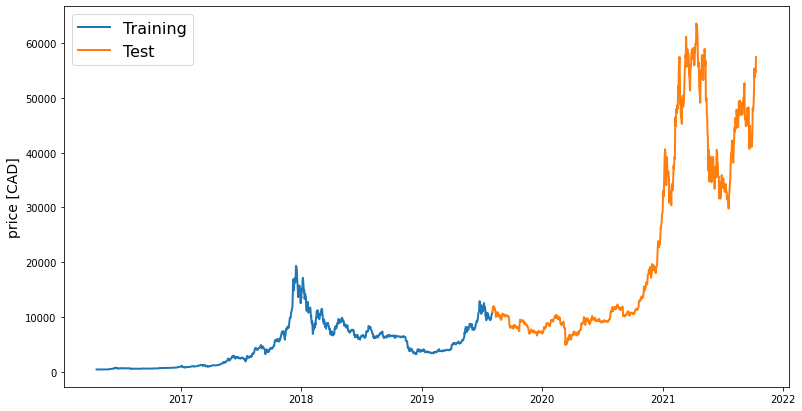

In [41]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [13]:
print(train)
print(test)


                high       low      open  volumefrom      volumeto     close
time                                                                        
2016-04-20    442.86    432.51    434.92    74361.53  3.265542e+07    441.16
2016-04-21    450.80    439.53    441.16    63127.80  2.816877e+07    449.34
2016-04-22    450.19    441.90    449.34    49710.33  2.222516e+07    445.28
2016-04-23    451.48    443.07    445.28    42358.77  1.899821e+07    450.08
2016-04-24    461.78    447.89    450.08    74434.28  3.398427e+07    457.56
...              ...       ...       ...         ...           ...       ...
2019-07-30   9749.53   9391.78   9506.93    28856.19  2.764023e+08   9595.52
2019-07-31  10123.94   9581.60   9595.52    42030.01  4.163431e+08  10089.25
2019-08-01  10488.81   9890.49  10089.25    43505.11  4.420373e+08  10409.79
2019-08-02  10666.64  10340.82  10409.79    44213.09  4.636883e+08  10528.99
2019-08-03  10915.00  10509.35  10528.99    34102.93  3.675365e+08  10820.41

In [23]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [24]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [25]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [43]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [65]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 100
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [66]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [67]:
#Early stopping using callbacks
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='min',verbose=1,patience=4) 

In [68]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, validation_data=(X_test,y_test), verbose=1, shuffle=True, callbacks=[es])

Epoch 1/40
27/27 [==============================] - 3s 24ms/step - loss: 0.0094 - val_loss: 0.0039
Epoch 2/40
27/27 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 3/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 4/40
27/27 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 5/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 6/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 7/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 8/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 9/40
27/27 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 11/40
27/27

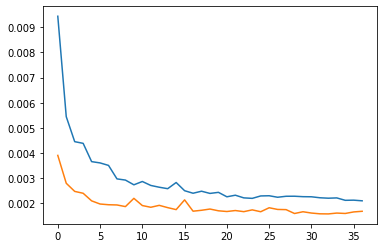

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [70]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.02887084803637267

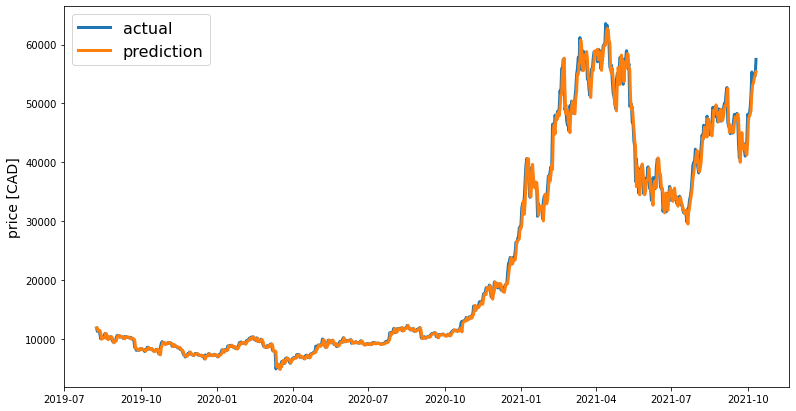

In [71]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)